In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import cv2
import os
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
gpus = tf.config.list_physical_devices('GPU')
from numba import cuda
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gc
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print("done")
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
face_cascade = cv2.CascadeClassifier('faces.xml')


done


True
160


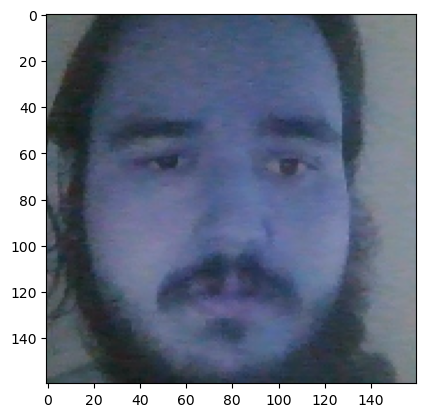

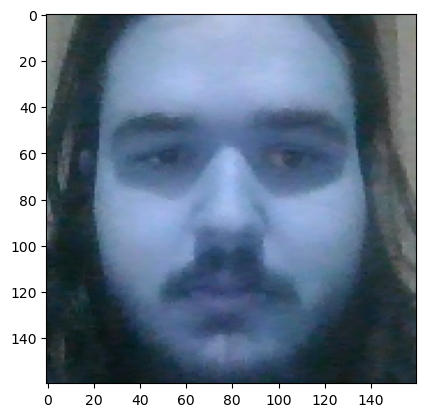

(160, 160, 3)
(160, 160, 3)
done


In [16]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
gpus = tf.config.list_physical_devices('GPU')

gpu_available = tf.test.is_gpu_available()
print(gpu_available)
path_ ="./Humans"
pathes=os.listdir("./Humans")
images_negative=[]
im_1, im_2 = cv2.imread('./positive_anchor/photo_positive.jpg'), cv2.imread('./positive_anchor/photo_anchor.jpg')
im_1_c, im_2_c = cv2.cvtColor(im_1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(im_2, cv2.COLOR_BGR2GRAY)
faces_1, faces_2 = face_cascade.detectMultiScale(im_1_c, 1.1, 4), face_cascade.detectMultiScale(im_2_c, 1.1, 4)
photo_1, photo_2 = None, None
for (x, y, w, h) in faces_1:
    photo_1=im_1[y:y+h,x:x+w,:]
    photo_1=cv2.resize(photo_1, (160, 160))
for (x, y, w, h) in faces_2:
    photo_2=im_2[y:y+h,x:x+w, :]
    photo_2=cv2.resize(photo_2, (160, 160))
print(len(photo_1))
plt.imshow(np.array(photo_1))
plt.show()
plt.imshow(np.array(photo_2))
plt.show()

im1_, im2_ = photo_1.astype(np.float32), photo_2.astype(np.float32)
positive, anchor = im1_/255.0, im2_/255.0
print(im1_.shape)
print(positive.shape)

gc.collect()
for path in pathes:
    
    name, ext = os.path.splitext(path)
    im = cv2.imread(path_+"/"+path)
    n=cv2.resize(im, (160, 160))
    gray = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        photo=n[y:y+h,x:x+w, :]
        photo=cv2.resize(photo, (160, 160))
    im_ = photo.astype(np.float32)
    im_ = im_/255.0
    del im
    del n
    images_negative.append(im_)
images_negative=np.array(images_negative).astype(np.float32)
print("done")

In [17]:
images_negative.shape

(7219, 160, 160, 3)

In [18]:
def convert(image, model):
  c_im=model.predict(image.reshape(1, 160, 160, 3))
  c_im=c_im/np.linalg.norm(c_im, ord=2, keepdims=False)
  return c_im
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self, anchor, positive, y_pred):
    super().__init__()
    self.anchor=anchor
    self.positive=positive
    self.y_pred=y_pred
  def call(self, y_true, y_pred):
    y_pred_c=self.y_pred
    anchor, positive = self.anchor, self.positive
    pos_d=tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=0)
    neg_d=tf.reduce_sum(tf.square(tf.subtract(anchor, y_pred_c)), axis=0)
    basic_l=tf.add(tf.subtract(pos_d, neg_d), 0.2)
    del anchor
    del positive
    return tf.reduce_sum(tf.maximum(basic_l, 0.0), axis=None)
loss_tracker = tf.keras.metrics.Mean(name="loss")
class CustomModel(tf.keras.Model):
  def __init__(self, anchor, positive):
    super(CustomModel, self).__init__()
    self.anchor=anchor.reshape(1, 160, 160, 3)
    self.positive=anchor.reshape(1, 160, 160, 3)
    self.l_inception = self.get_inception()
    self.l_inception_2 = self.get_inception_two()
    self.l_1=tf.keras.layers.Conv2D(input_shape=(160, 160, 3),
                            kernel_size=(7,7),
                            filters=32,
                            activation="relu")
    self.l_2_1=tf.keras.layers.Normalization()
    self.l_2=tf.keras.layers.MaxPooling2D(pool_size=(3,3))
    self.l_4_1=tf.keras.layers.Normalization()
    self.l_4=tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))
    self.l_10=tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.l_13=tf.keras.layers.Flatten()
    self.l_14=tf.keras.layers.Dense(128, kernel_regularizer="l2")
  def get_inception(self):
    l_incept=[]
    for x in range(12):
        l=[]
        l_4=tf.keras.layers.Conv2D(kernel_size=(1,1), filters=32,activation="relu")
        l_5=tf.keras.layers.Conv2D(kernel_size=(1,1), filters=32, activation="relu")
        l_7_f=tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))
        l_9_f=tf.keras.layers.Conv2D(kernel_size=(2,2), strides=(2,2), filters=100, activation="relu")
        l_10_f=tf.keras.layers.Conv2D(kernel_size=(2,2), strides=(2,2), filters=100, activation="relu")
        l.append(l_4)
        l.append(l_5)
        l.append(l_7_f)
        l.append(l_9_f)
        l.append(l_10_f)
        l_incept.append(l)
    return l_incept
  def get_inception_two(self):
    l_incept=[]
    for x in range(12):
        l=[]
        l_4=tf.keras.layers.Conv2D(kernel_size=(1,1), filters=32,activation="relu")
        l_5=tf.keras.layers.Conv2D(kernel_size=(1,1), filters=32, activation="relu")
        l_7_f=tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding="same", strides=(1,1))
        l_9_f=tf.keras.layers.Conv2D(kernel_size=(2,2), padding="same", strides=(1,1), filters=120, activation="relu")
        l_10_f=tf.keras.layers.Conv2D(kernel_size=(2,2), padding="same", strides=(1,1), filters=120, activation="relu")
        l.append(l_4)
        l.append(l_5)
        l.append(l_7_f)
        l.append(l_9_f)
        l.append(l_10_f)
        l_incept.append(l)
    return l_incept
  def make_inception(self, ind, inp):
    l_4=self.l_inception[ind][0](inp)
    l_5=self.l_inception[ind][1](inp)
    l_7_f=self.l_inception[ind][2](inp)
    l_9_f=self.l_inception[ind][3](l_4)
    l_10_f=self.l_inception[ind][4](l_5)
    l_11=tf.keras.layers.concatenate([l_7_f, l_9_f, l_10_f], axis=3)
    return l_11
  def make_inception_two(self, ind, inp):
    l_4=self.l_inception_2[ind][0](inp)
    l_5=self.l_inception_2[ind][1](inp)
    l_7_f=self.l_inception_2[ind][2](inp)
    l_9_f=self.l_inception_2[ind][3](l_4)
    l_10_f=self.l_inception_2[ind][4](l_5)
    l_11=tf.keras.layers.concatenate([l_7_f, l_9_f, l_10_f], axis=3) 
    return l_11
  def call(self, inputs, training=False):
    l_1=self.l_1(inputs)
    l_2=self.l_2(l_1)
    l_3=self.make_inception(0, l_2)
    l_4=self.l_4(l_3)
    l_5=self.make_inception_two(1, l_4)
    l_6=self.make_inception_two(2, l_5)
    l_7=self.make_inception(3, l_6)
    l_8=self.make_inception_two(4, l_7)
    l_9=self.make_inception_two(5, l_8)
    l_10=self.make_inception_two(6, l_9)
    l_11=self.make_inception_two(7, l_10)
    l_12=self.make_inception_two(8, l_11)
    l_13=self.make_inception(9, l_12)    
    l_14=self.make_inception(10, l_13)    
    l_16=self.l_13(l_14)
    l_17=self.l_14(l_16)
    return l_17

  @tf.function(jit_compile=True)
  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=False)
      y_pred = tf.divide(y_pred, tf.linalg.norm(y_pred, ord=2, keepdims=False))
      anchor = self(self.anchor, training=False)
      anchor = tf.divide(anchor, tf.linalg.norm(anchor, ord=2, keepdims=False))
      positive = self(self.positive, training=False)
      positive = tf.divide(positive, tf.linalg.norm(positive, ord=2, keepdims=False))
      loss = CustomLoss(anchor=anchor, positive=positive, y_pred=y_pred).call(y_true=y, y_pred=y_pred)

        # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

        # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Compute our own metrics
    loss_tracker.update_state(loss)
    return {"loss": loss_tracker.result()}

  @property
  def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
    return [loss_tracker]

  

In [19]:

X_train,y_train=images_negative[:4000, :, :, :], images_negative[:int(len(images_negative)/4), :, :, :]
print("completed")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print(tf.config.experimental.get_memory_usage('GPU:0'))

model=CustomModel(anchor=anchor, positive=positive)
model.compile(optimizer="adam")
model.fit(epochs=12, batch_size=64, x=images_negative, y=np.random.randn(len(images_negative),1), verbose = 1)


completed
18186240
Epoch 1/12
113/113 [==============================] - 55s 293ms/step - loss: 0.2795
Epoch 2/12
113/113 [==============================] - 16s 144ms/step - loss: 0.0090
Epoch 3/12
113/113 [==============================] - 16s 144ms/step - loss: 0.0069
Epoch 4/12
113/113 [==============================] - 16s 144ms/step - loss: 0.0086
Epoch 5/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0044
Epoch 6/12
113/113 [==============================] - 16s 144ms/step - loss: 0.0060
Epoch 7/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0077
Epoch 8/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0040
Epoch 9/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0064
Epoch 10/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0104
Epoch 11/12
113/113 [==============================] - 16s 145ms/step - loss: 0.0048
Epoch 12/12
113/113 [==============================] - 

In [20]:
model.summary()


Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          multiple                  1056      
                                                                 
 conv2d_98 (Conv2D)          multiple                  1056      
                                                                 
 max_pooling2d_26 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          multiple                  12900     
                                                                 
 conv2d_100 (Conv2D)         multiple                  12900     
                                                                 
 conv2d_101 (Conv2D)         multiple                  0 (unused)
                                                    

In [24]:
vid = cv2.VideoCapture(0)

while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    # Display the resulting frame
    cv2.imshow('frame', frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        photo=frame[y:y+h,x:x+w, :]
        photo=cv2.resize(np.array(photo), (160, 160))
        photo=photo/255.0
        f_d=convert(photo, model)
        print(positive.shape)
        dist=np.float32(np.linalg.norm(f_d-convert(positive, model)))*100
        print(dist)
        if dist>0.7:
            print("unable")
        else:
            print("success")

    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

1/1 [==============================] - 0s 35ms/step
(160, 160, 3)
1/1 [==============================] - 0s 36ms/step
0.7260746322572231
unable
1/1 [==============================] - 0s 45ms/step
(160, 160, 3)
1/1 [==============================] - 0s 41ms/step
0.7127007935196161
unable
1/1 [==============================] - 0s 39ms/step
(160, 160, 3)
1/1 [==============================] - 0s 45ms/step
0.738842599093914
unable
1/1 [==============================] - 0s 35ms/step
(160, 160, 3)
1/1 [==============================] - 0s 42ms/step
0.7831808179616928
unable
1/1 [==============================] - 0s 44ms/step
(160, 160, 3)
1/1 [==============================] - 0s 42ms/step
0.7842618972063065
unable
1/1 [==============================] - 0s 49ms/step
(160, 160, 3)
1/1 [==============================] - 0s 42ms/step
0.7929826155304909
unable
1/1 [==============================] - 0s 45ms/step
(160, 160, 3)
1/1 [==============================] - 0s 45ms/step
0.7660714909434319


KeyboardInterrupt: 